# RQ4: How frequently do developers use the conversion functions?


## Data Preparation

In [40]:
from pathlib import Path

import pandas as pd
# extracted compressed results
!unzip -o ../../data/sfconvertbot_pr_metadata.csv.zip -d ../../data
# Load the dataset
df = pd.read_csv(Path('../../data/sfconvertbot_pr_metadata.csv'))
print("Number of PRs: ", len(df))

# remove rows with missing values
df = df.dropna()
print("Number of PRs after removing missing values: ", len(df))

# remove rows with invalid JSONs
df = df[df['discussion_metadata'].str.startswith('{')]
print("Number of PRs after removing invalid JSONs: ", len(df))

# add a date column
df['date'] = df['time'].str.split('T').str[0]
df['date'] = df['date'].str.split(' ').str[0]
# ensure date column is a datetime object
df['date'] = pd.to_datetime(df['date'])
# filter in place, keep only commits before Oct 31 2024 (including)
df = df[df['date'] <= pd.Timestamp(2024, 10, 31)]
print("Number of PRs after filtering by date: ", len(df))
# exclude PRs made on spaces/safetensors/convert
df = df[~df['pr_url'].str.contains('/spaces/safetensors/convert/discussions')]
print("Number of PRs after filtering by URL: ", len(df))
# show number of repos 
print("Number of repositories: ", df['model_id'].nunique())
# show avg number of PRs per repo
print("Average number of PRs per repository: ", df['model_id'].value_counts().mean())
# show first commit date
print("First commit date: ", df['date'].min())



# remove the extracted zip file
!rm ../../data/sfconvertbot_pr_metadata.csv

Archive:  ../../data/sfconvertbot_pr_metadata.csv.zip
  inflating: ../../data/sfconvertbot_pr_metadata.csv  
Number of PRs:  45394
Number of PRs after removing missing values:  45311
Number of PRs after removing invalid JSONs:  45307
Number of PRs after filtering by date:  45072
Number of PRs after filtering by URL:  45070
Number of repositories:  36296
Average number of PRs per repository:  1.2417346264051135
First commit date:  2023-03-16 00:00:00


## Extracting PR Statuses


In [33]:
from tqdm import tqdm
import json


def label_status(row: pd.Series) -> str:
    # check if the PR has conflicts
    if row['conflicts']:
        return f"{row['status']} (has conflicts)"
    return row['status']


# Extract status changes from discussion metadata
for index, row in tqdm(df.iterrows(), total=len(df)):
    # add a column to track status changes
    status_changes = []
    discussion = json.loads(row['discussion_metadata'])['discussion']
    for event in discussion['events']:
        event_type = event['type']
        if event_type == 'status-change':
            status_changes.append(event['data']['status'])

    df.at[index, 'status_changes'] = ";".join(status_changes)

    # add a column to track files with conflicts
    df.at[index, 'conflicts'] = ""
    header = json.loads(row['header_metadata'])
    df.at[index, 'status'] = header['discussion']['status']
    # check if there are conflicting files
    conflicting_files = header['discussion'].get('filesWithConflicts', [])
    df.at[index, 'conflicts'] = ";".join(conflicting_files)

    # adjust the status
    df.at[index, 'status'] = label_status(df.loc[index])

# show only those in 2022
df_2022 = df[df['date'].dt.year == 2022]
df_2022

100%|██████████| 45070/45070 [00:15<00:00, 2869.84it/s]


,pr_url,discussion_metadata,header_metadata,model_id,time,date,status_changes,conflicts,status


## 100% stacked bar chart per year for the distribution of different status.


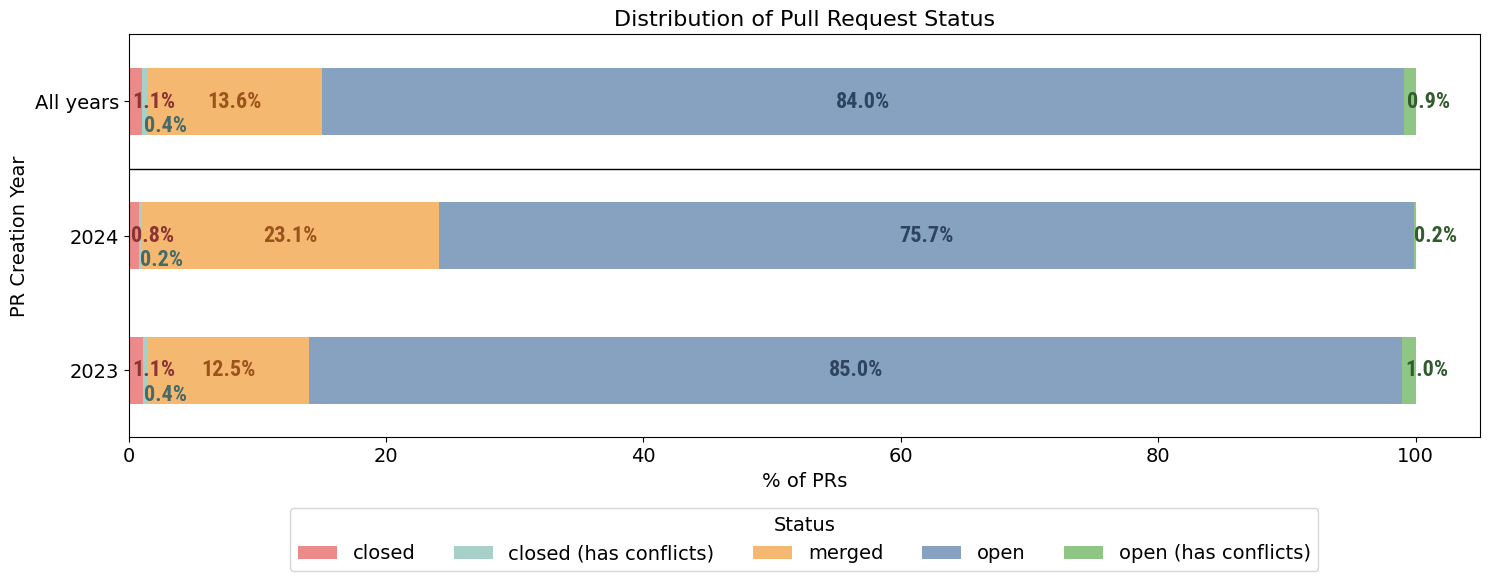

In [36]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

# Add a year column
df['year'] = df['date'].dt.year

# Group by year and status, and calculate counts
status_counts = df.groupby(['year', 'status']).size().unstack(fill_value=0)

# Calculate percentage distribution for each year
status_percentage = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# Calculate total counts for all years and add as a new row
total_counts = df['status'].value_counts(normalize=True) * 100  # Percentage distribution for the entire dataset
status_percentage.loc['All years'] = total_counts.reindex(status_percentage.columns).fillna(0)  # Add 'Total' row

# Define Tableau-like color palette for the status categories
colors = {
    'open': '#87a1c1',              # Lighter Blue
    'merged': '#f5b870',            # Lighter Orange
    'closed': '#ec8a89',            # Lighter Red
    'closed (has conflicts)': '#a7d0c8',  # Lighter Teal
    'open (has conflicts)': '#8fc685'     # Lighter Green
}


# Define even darker versions of the Tableau-like color palette
darker_colors = {
    'open': '#2d4460',              # Even Darker Blue
    'merged': '#9a531b',            # Even Darker Orange
    'closed': '#8a3434',            # Even Darker Red
    'closed (has conflicts)': '#466a68',  # Even Darker Teal
    'open (has conflicts)': '#325c2d'     # Even Darker Green
}

# Load the Roboto Condensed font from your local assets folder
roboto_condensed = FontProperties(fname='../../assets/RobotoCondensed-Bold.ttf')

# Plot the 100% stacked bar chart as horizontal with Tableau-like colors
fig, ax = plt.subplots(figsize=(15, 6))
status_percentage.plot(kind='barh', stacked=True, ax=ax, color=[colors[status] for status in status_percentage.columns])

# Add data labels for each segment with matching colors
for i, (year, row) in enumerate(status_percentage.iterrows()):
    cumulative = 0
    delta = 0.18  # Offset for small segments
    was_small = False
    for status, value in row.items():
        if value > 5:  # Only display labels for segments > 5% to prevent overlap
            ax.text(cumulative + value / 2, i, f"{value:.1f}%", ha='center', va='center', 
                    fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                    color=darker_colors[status])  # Set text color to match bar color
            was_small = False
        elif value > 0:
            # For small segments, place the label outside with matching color
            ax.text(cumulative + value / 4 , i + (delta if was_small else 0), f"{value:.1f}%", ha='left', va='center', 
                    fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                    color=darker_colors[status])
            delta = -delta
            was_small = True
        cumulative += value

# Add a red line separating the "Total" bar from the yearly data
ax.axhline(y=len(status_percentage) - 1.5, color='black', linewidth=1)

# Customize plot with larger font sizes
plt.title('Distribution of Pull Request Status', fontsize=16)
plt.ylabel('PR Creation Year', fontsize=14)
plt.xlabel('% of PRs', fontsize=14)
# increase tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Move the legend outside and below the chart with increased label size
plt.legend(title='Status', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(status_percentage.columns), fontsize=14, title_fontsize=14)
plt.tight_layout()

# Save the plot to a PDF
plt.savefig('RQ4StatusDistribution.pdf', format='pdf', bbox_inches='tight')

plt.show()


## Identify Relevant Discussions

Criteria:
1. PR has at least two non-empty comment.
2. PR has at least two different authors (not counting the SFConvertBot) engaging in the discussion.
3. The average comment size is more than 4 words.

In [37]:
from nb_utils import RESULTS_DIR
from tqdm import tqdm
import json

min_num_authors = 2
min_num_comments = 2
min_avg_comment_size = 0

output_file = RESULTS_DIR / 'sfconvertbot_pr_metadata_filtered.csv'
# create a dataframe to store the filtered PRs
df_filtered = pd.DataFrame(columns=df.columns)
# create lambda function that checks whether string.lower() == 'sfconvertbot'
is_sfconvertbot = lambda x: x.lower() == 'sfconvertbot'

# iterate over dataframe
for index, row in tqdm(df.iterrows(), total=len(df)):
    # parse as JSON (it should be a string)
    discussion = json.loads(row['discussion_metadata'])['discussion']
    # extract events and original author
    events = discussion['events']
    original_author = discussion['author']
    # criteria:
    num_words, num_non_empty_comments = 0, 0
    authors = set()
    if not is_sfconvertbot(original_author["name"]):
        authors.add(original_author["name"])

    for event in events:
        # print("\t",event)
        event_type = event['type']
        if event_type == 'comment' and not event['data']['hidden']:
            event_author = event['author']
            num_non_empty_comments += 1
            if not is_sfconvertbot(event_author["name"]):
                authors.add(event_author["name"])
            num_words += len(event['data']['latest']['raw'].split())

    should_include = (num_non_empty_comments >= min_num_comments and
                      len(authors) >= min_num_authors and
                      num_words / num_non_empty_comments >= min_avg_comment_size)
    # add the row to the filtered dataframe
    if should_include:
        df_filtered.loc[len(df_filtered)] = row
        title = f"{discussion['title']} by {original_author['name']} ({row['model_id']})"
        df_filtered.loc[len(df_filtered) - 1, 'title'] = title
        df_filtered.loc[len(df_filtered) - 1, 'num_comments'] = num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'num_authors'] = len(authors)
        df_filtered.loc[len(df_filtered) - 1, 'avg_comment_size'] = num_words / num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'authors'] = ";".join(authors)

# add a source column
df_filtered['source'] = 'SFConvertBot PRs'
# rename PR URL column to url
df_filtered.rename(columns={'pr_url': 'url'}, inplace=True)
# rename discussion_metadata to json_content
df_filtered.rename(columns={'discussion_metadata': 'json_content'}, inplace=True)
# reorder columns
df_filtered = df_filtered[['source', 'title', 'url', 'num_comments', 'num_authors', 'avg_comment_size', 'authors']]
# save the filtered dataframe
df_filtered.to_csv(output_file, index=True)
print("Number of PRs after filtering: ", len(df_filtered))
print("Saved to: ", output_file)

100%|██████████| 45070/45070 [00:05<00:00, 8776.16it/s] 

Number of PRs after filtering:  13
Saved to:  ../../results/sfconvertbot_pr_metadata_filtered.csv
